# Comparison between nestle and dynesty

In [1]:
import os
import sys
from scipy.special import ndtri
import numpy as np
from matplotlib import pyplot as plt
import corner
# import Nestle
import nestle
#dynesty
import dynesty

%matplotlib inline

In [2]:
#Create data

In [3]:
"""
Setup a model and data
"""


# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 1000
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    
    return m*x + c

# create the data - the model plus Gaussian noise
sigma = 0.05 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)


LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(sigma)

# loglike y prior_transform son las mismas funciones para nestle y dynesty

In [4]:
def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -2.  # lower bound on uniform prior on c
    cmax = 6.   # upper bound on uniform prior on c

    #mmu = 0.     # mean of Gaussian prior on m
    #msigma = 5. # standard deviation of Gaussian prior on m

    #m = mmu + msigma*ndtri(mprime) # convert back to m
    mmax = 10
    mmin = 0
    m = mprime*(mmax-mmin) + mmin
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)

In [5]:
def loglikelihood_nestle(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

# Nestle:


In [6]:
nlive = 1024     # number of live points
method = 'classic' # use MutliNest algorithm
ndims = 2        # two parameters
tol= 0.5         # the stopping criterion (this is the nestle default, so doesn't need to be set)

res = nestle.sample(loglikelihood_nestle, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol)

logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

# output marginal likelihood
print('Marginalised evidence is {} ± {}'.format(logZnestle, logZerrnestle))

# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
#keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
#postsamples = res.samples[keepidx,:]
postsamples = res.samples

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

# plot posterior samples (if corner.py is installed)
#try:
#    import matplotlib as mpl
#    mpl.use("Agg") # force Matplotlib backend to Agg
 # import corner.py
#except ImportError:
#    sys.exit(1)

#fig = corner.corner(postsamples, labels=[r"$m$", r"$c$"], color = 'k', truths=[m, c])
#fig.savefig('dynesty.png')



Marginalised evidence is 1539.215685891708 ± 0.12345999494436147
Number of posterior samples is 18911


In [7]:
print("logLike: {}".format(res.logl[-1]))

logLike: 1555.7147274786648


# dynesty:


In [8]:
nlive = 1024      # number of (initial) live points
bound = 'multi'   # use MutliNest algorithm
sample = 'rwalk'  # use the random walk to draw new samples
#ndims = 2         # two parameters

###dsampler = dynesty.DynamicNestedSampler(loglikelihood_nestle, prior_transform, ndims,
###                                bound=bound, sample=sample)
###dsampler.run_nested(nlive_init=nlive)
###dres = dsampler.results

###dlogZdynesty = dres.logz[-1]        # value of logZ
###dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

# ###output marginal likelihood
###print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
###dweights = np.exp(dres['logwt'] - dres['logz'][-1])
###dpostsamples = resample_equal(dres.samples, dweights)

###print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))

# Now run with the static sampler
sampler2 = dynesty.NestedSampler(loglikelihood_nestle, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)
sampler2.run_nested(dlogz=0.01)

res2 = sampler2.results

logZdynesty = res2.logz[-1]        # value of logZ
logZerrdynesty = res2.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

# output marginal likelihood
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

# get the posterior samples
weights = np.exp(res2['logwt'] - res2['logz'][-1])
#postsamples2 = dynesty.utils.resample_equal(res2.samples, weights)
postsamples2 = res2.samples

#print('Number of posterior samples (using static sampler) is {}'.format(postsamples2.shape[0]))

# plot posterior samples (if corner.py is installed)


###fig = corner.corner(dpostsamples, labels=[r"$m$", r"$c$"], truths=[m, c], hist_kwargs={'density': True})
#fig = corner.corner(postsamples, fig=fig, color='r', hist_kwargs={'density': True})
#plt.show()


21377it [00:37, 575.02it/s, +1024 | bound: 115 | nc: 1 | ncall: 479332 | eff(%):  4.673 | loglstar:   -inf < 1555.827 <    inf | logz: 1539.572 +/-  0.173 | dlogz:  0.000 >  0.010] 


Marginalised evidence (using static sampler) is 1539.5718962721219 ± 0.17250946335064735


## testing dynesty object:


In [9]:
print(res2.keys())
print(res2.samples)
print(round(res2.logz[-1],3))
print(str(round(res2.logz[-1], 3)) + ' +/- ' + str(round(res2.logzerr[-1], 3)))
print("logLike : {} ".format(round(res2.logl[-1], 3)))

print("logz : {} +/- {} ".format(round(res2.logz[-1], 3), round(res2.logzerr[-1], 3)))
print("h : {}".format(round(res2.information[-1],3)))
summary = res2.summary()
#summary
type(res2.niter)
print(sum(res2.ncall))


dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])
[[9.99759105 5.67400647]
 [9.95239388 5.72111264]
 [9.84409939 5.28320337]
 ...
 [3.50041612 1.19811794]
 [3.50042062 1.19810378]
 [3.50041912 1.19810089]]
1539.572
1539.572 +/- 0.173
logLike : 1555.827 
logz : 1539.572 +/- 0.173 
h : 15.244
Summary
nlive: 1024
niter: 21377
ncall: 479332
eff(%):  4.673
logz: 1539.572 +/-  0.173
479332


In [10]:
#buscando dlogz
mean = round(np.mean(res2.samples[:, 0]), 3)
std = round(np.std(res2.samples[:, 0]), 3)
print(np.shape(res2.samples))
print("m : {} +/- {}".format(mean, std))
mean = round(np.mean(res2.samples[:,1]), 3)
std = round(np.std(res2.samples[:,1]), 3)
#print(np.shape(res2.samples))
print("c : {} +/- {}".format(mean, std))


(22401, 2)
m : 3.564 +/- 0.84
c : 1.334 +/- 1.088


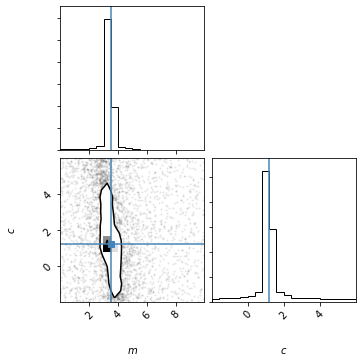

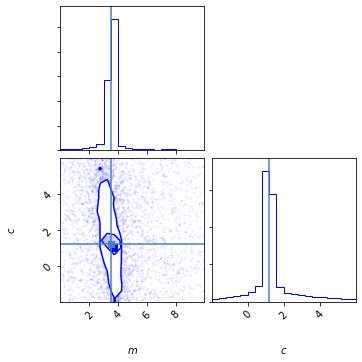

In [11]:
fig = corner.corner(postsamples2, labels=[r"$m$", r"$c$"], color = 'k', truths=[m, c])
#fig = corner.corner(postsamples, fig=fig, color='r', hist_kwargs={'density': True})
fig2 = corner.corner(postsamples, labels=[r"$m$", r"$c$"], color = 'b', truths=[m, c])

#fig.savefig('dynesty.png')

plt.show()

In [12]:
from anesthetic import MCMCSamples
from anesthetic import NestedSamples

In [14]:
nested = NestedSamples(res.samples)
ns_output = nested.ns_output()

AttributeError: 'NestedSamples' object has no attribute 'nlive'